Import all librairie use

In [238]:
import os
import tarfile
import matplotlib
import math

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ipywidgets as widgets
import seaborn as sns

from numpy.random import default_rng
from datetime import datetime
from datetime import timedelta
from six.moves import urllib
from ipywidgets import interact, interactive, fixed, interact_manual
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.base import clone
from sklearn.svm import SVR
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification

# Data directory
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/RubisetCie/Project-Artificial-Intelligence/main/Data/"
DESTINATION_PATH = "datasets"
SOURCE_NAME = "in_time.csv"

# Setup figures saving directory
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")

# Setup matplotlib
%matplotlib inline
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12


In [188]:
# Function to save a figure as image file
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Function to fetch data
def fetch_data(url=DOWNLOAD_ROOT, filename=SOURCE_NAME, destination=DESTINATION_PATH):
    if not os.path.isdir(destination):
        os.makedirs(destination)
    csv_path = os.path.join(destination, filename)
    urllib.request.urlretrieve(url+filename, csv_path)
    
# Function to load up data
def load_data(source=DESTINATION_PATH, filename=SOURCE_NAME):
    csv_path = os.path.join(source, filename)
    return pd.read_csv(csv_path)

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())
    
def predict_score():
    list_pred = clf.predict(test_ds)
    list_result = []
    valid = 0

    for (indexA), (indexP) in zip(test_attrition.index, list_pred):
        if indexP !=  test_attrition[indexA]:
            if indexP == 0:
                list_result.append(0)
            else:
                list_result.append(-1)
        else:  
            list_result.append(1)
            valid += 1
    print(round(valid/ len(list_result),3)*100,"%")

In [3]:
# Importation of the data
fetch_data(filename="general_data.csv")
fetch_data(filename="manager_survey_data.csv")
fetch_data(filename="employee_survey_data.csv")
fetch_data(filename="in_time.csv")
fetch_data(filename="out_time.csv")


in_time = load_data(filename="in_time.csv")
out_time = load_data(filename="out_time.csv")
general = load_data(filename="general_data.csv")
manager = load_data(filename="manager_survey_data.csv")
employee = load_data(filename="employee_survey_data.csv")

In [4]:
# Drop columns with only null data
in_time.dropna(axis=1, how='all', inplace=True)
out_time.dropna(axis=1, how='all', inplace=True)
general.dropna(axis=1, how='all', inplace=True)
manager.dropna(axis=1, how='all', inplace=True)
employee.dropna(axis=1, how='all', inplace=True)

in_time.rename(columns={"Unnamed: 0": "EmployeeID"}, inplace=True)
out_time.rename(columns={"Unnamed: 0": "EmployeeID"}, inplace=True)

in_time.set_index("EmployeeID", inplace=True)
out_time.set_index("EmployeeID", inplace=True)

In [5]:
# Remodelisation of the in-out Dataframe
epoch = datetime(1900, 1, 1)
    
for (i1, rowI), (i2, rowO) in zip(in_time.iterrows(), out_time.iterrows()):
    for col in in_time.columns:
        if str(rowI[col]) != "nan":
            in_time.loc[i1, col] = (datetime.strptime(str(rowI[col]).split()[1],'%H:%M:%S') - epoch).total_seconds()
            out_time.loc[i2, col] = (datetime.strptime(str(rowO[col]).split()[1],'%H:%M:%S') - epoch).total_seconds()
            
in_mean_seconds = in_time.mean(axis=1, skipna = True)
out_mean_seconds = out_time.mean(axis=1, skipna = True)

in_mean = in_mean_seconds.copy(deep=False)
out_mean = out_mean_seconds.copy(deep=False)

for (indexI), (indexO) in zip(in_mean_seconds.index, out_mean_seconds.index):
    in_mean[indexI] = datetime.strptime(str(timedelta(seconds=round(in_mean_seconds[indexI]))),'%H:%M:%S').time()
    out_mean[indexO] = datetime.strptime(str(timedelta(seconds=round(out_mean_seconds[indexO]))),'%H:%M:%S').time()
    
d = {'in_mean': in_mean, 'out_mean': out_mean, 'time_mean': (out_mean_seconds - in_mean_seconds) / 3600 }
io_mean = pd.DataFrame(data=d)

In [6]:
d = {'time_mean': (out_mean_seconds - in_mean_seconds) / 3600 }
io_mean = pd.DataFrame(data=d)

In [7]:
# Dropping the gender and "over 18" fields
general = general.drop(columns=["Gender", "Over18"])

# Converting boolean to binary (0 or 1)
general.replace({'No': 0, 'Yes':1}, inplace=True)
general.replace({'Male': 0, 'Female':1}, inplace=True)

# Encoding ordinal fields
ordinal_encoder = OrdinalEncoder()
general["BusinessTravel"] = ordinal_encoder.fit_transform(general[["BusinessTravel"]])

# Encoding non-ordinal fields
labelbinarizer_encoder = LabelBinarizer()
general_department = pd.DataFrame(labelbinarizer_encoder.fit_transform(general["Department"]))
general_department.rename(columns=dict(zip(general_department.columns, ("Department " + sub for sub in general["Department"].unique()))), inplace=True)
general_education = pd.DataFrame(labelbinarizer_encoder.fit_transform(general["EducationField"]))
general_education.rename(columns=dict(zip(general_education.columns, ("EducationField " + sub for sub in general["EducationField"].unique()))), inplace=True)
general_role = pd.DataFrame(labelbinarizer_encoder.fit_transform(general["JobRole"]))
general_role.rename(columns=dict(zip(general_role.columns, ("JobRole " + sub for sub in general["JobRole"].unique()))), inplace=True)
general_martial = pd.DataFrame(labelbinarizer_encoder.fit_transform(general["MaritalStatus"]))
general_martial.rename(columns=dict(zip(general_martial.columns, ("MaritalStatus " + sub for sub in general["MaritalStatus"].unique()))), inplace=True)

# Combining all the prepared data
general = pd.concat([general, general_department, general_education, general_role, general_martial], axis=1).drop(["Department", "EducationField", "JobRole", "MaritalStatus"], axis=1)

In [250]:
# Merging all data in one Dataframe
dataset = general.merge(manager, how="left", on="EmployeeID").merge(employee, how="left", on="EmployeeID").merge(io_mean, how="left", on="EmployeeID")
        
# Dropping nulls
dataset.dropna(inplace=True)

dataset.to_csv(os.path.join(DESTINATION_PATH, "dataset.csv"), index=False)

In [302]:
#Divide into NumericalColumns
columns=dataset.columns.tolist()
num_col_eda=['Age','DistanceFromHome','PercentSalaryHike','MonthlyIncome','TotalWorkingYears','YearsAtCompany']

#Divide into CategoricalColumns
num_attrition=num_col_eda+['Attrition']
Education=['Below-College','College','Bachelor','Master','Doctor']
EnvironmentSatisfaction=['Low','Medium','High','Very High']
JobInvolvement=['Low','Medium','High','Very High']
JobSatisfaction=['Low','Medium','High','Very High']
RelationshipSatisfaction=['Low','Medium','High','Very High']
PerformanceRating=['Low','Good','Excellent','Outstanding']
WorkLifeBalance=['Bad','Good','Better','Best']

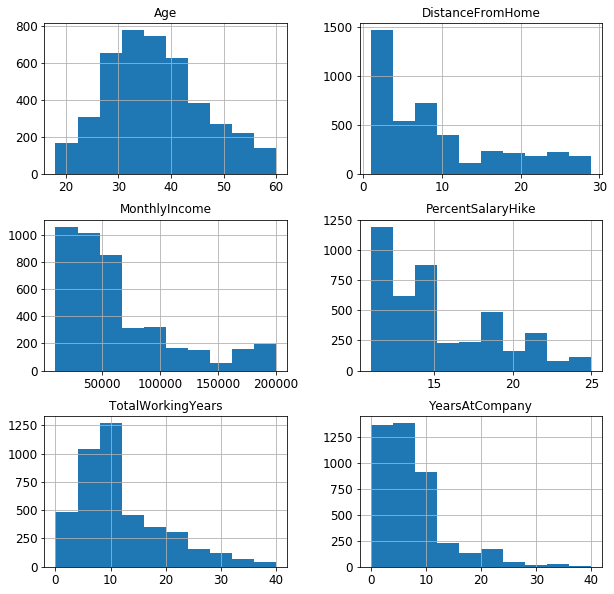

In [303]:
dataset[num_col_eda].hist(figsize=(10,10))
plt.show()

<Figure size 1152x1440 with 0 Axes>

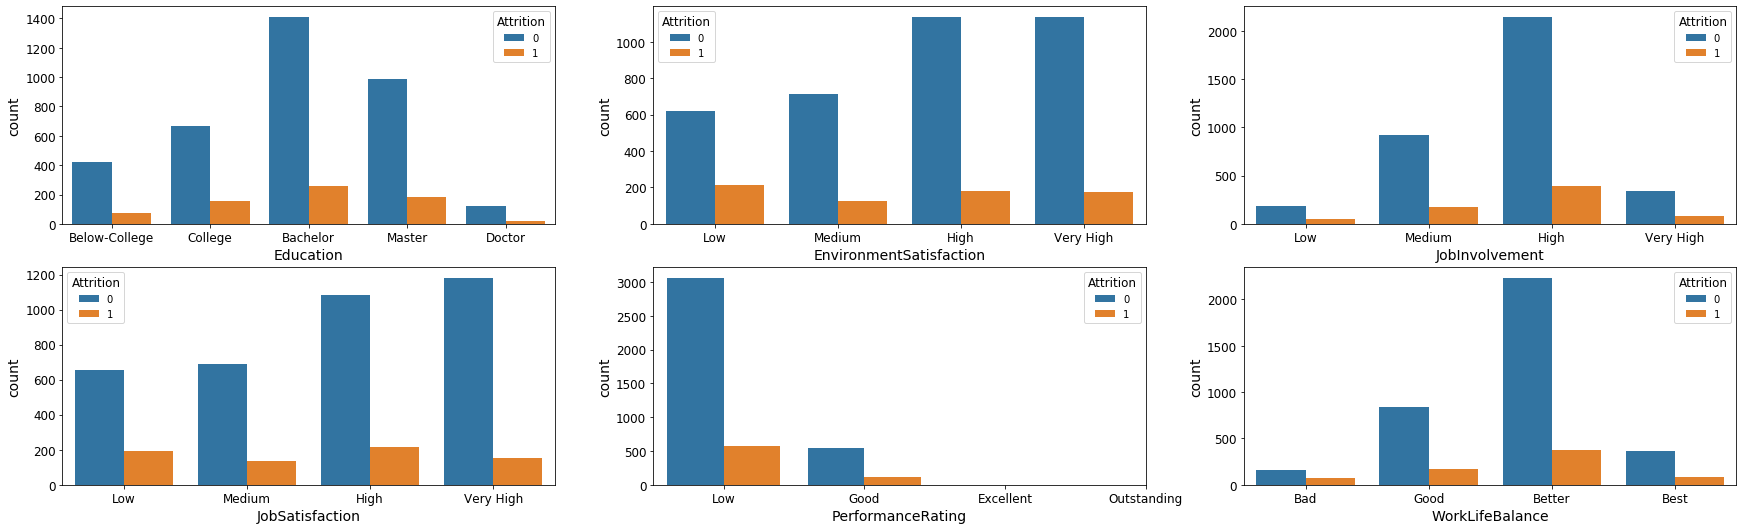

In [305]:
val=[Education,EnvironmentSatisfaction,JobInvolvement,JobSatisfaction,PerformanceRating,WorkLifeBalance]
cat1=['Education','EnvironmentSatisfaction','JobInvolvement','JobSatisfaction','PerformanceRating','WorkLifeBalance']

cat_col_eda=set(columns) - set(num_col_eda)
cat_col_eda=set(cat_col_eda) - set(cat1)
fig = plt.figure(figsize=(16,20))

#2. chaning nums as x_ticks to   categorys as x_ticks
fig = plt.figure(figsize=(30,28))
for idx,i in enumerate(zip(cat1,val)):
    ax=plt.subplot(6,3,idx+1)
    sns.countplot(dataset[i[0]],hue=dataset['Attrition'],ax=ax)
    ax.set(xticks=range(len(i[1])), xticklabels=[j for j in i[1]])
plt.show()

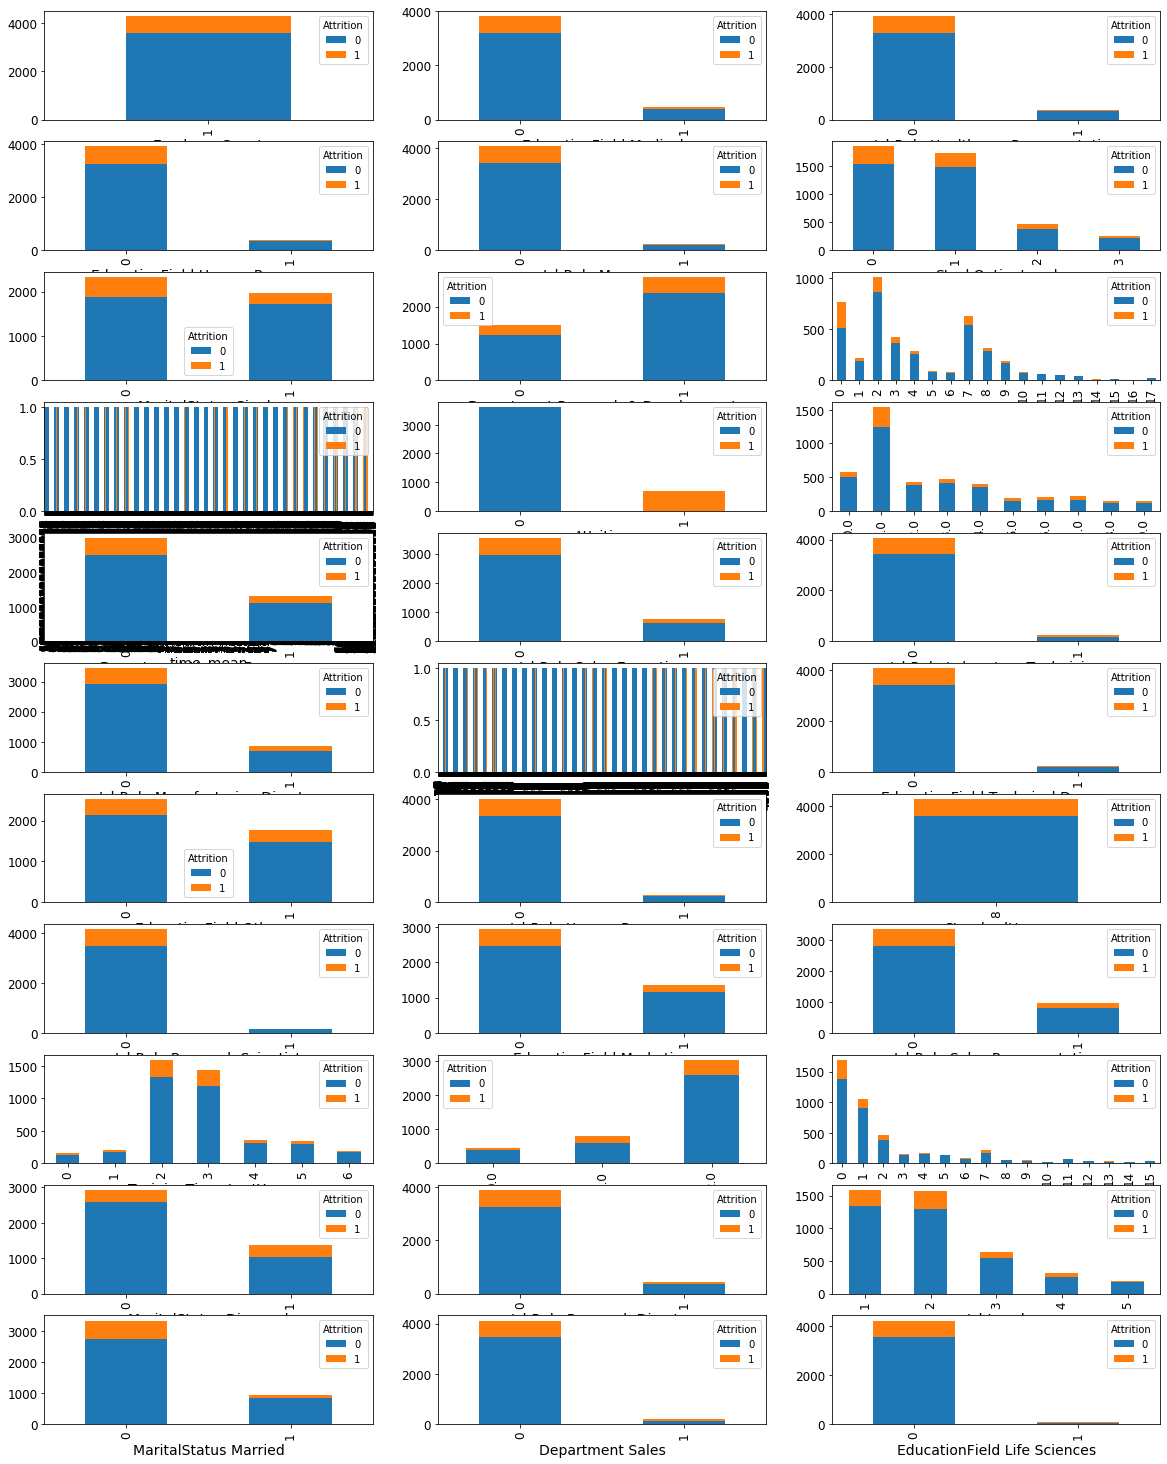

['EmployeeCount', 'EducationField Medical', 'JobRole Healthcare Representative', 'EducationField Human Resources', 'JobRole Manager', 'StockOptionLevel', 'MaritalStatus Single', 'Department Research & Development', 'YearsWithCurrManager', 'time_mean', 'Attrition', 'NumCompaniesWorked', 'Department Human Resources', 'JobRole Sales Executive', 'JobRole Laboratory Technician', 'JobRole Manufacturing Director', 'EmployeeID', 'EducationField Technical Degree', 'EducationField Other', 'JobRole Human Resources', 'StandardHours', 'JobRole Research Scientist', 'EducationField Marketing', 'JobRole Sales Representative', 'TrainingTimesLastYear', 'BusinessTravel', 'YearsSinceLastPromotion', 'MaritalStatus Divorced', 'JobRole Research Director', 'JobLevel', 'MaritalStatus Married', 'Department Sales', 'EducationField Life Sciences']


In [317]:
#Divide into CategoricalColumns
#1. with categorys as x_ticks
fig = plt.figure(figsize=(20,26))
for idx,i in enumerate(cat_col_eda):
    crosstab = pd.crosstab(index=dataset[i], columns=dataset["Attrition"])
    ax=plt.subplot(11,3,idx+1)
    crosstab.plot(kind="bar",stacked=True,ax=ax)
    #sns.countplot(x=i[0],data=final_df,ax=ax)
    #ax.set(xticks=range(len(i[1])), xticklabels=[j for j in i[1]])
plt.show()
print(list(cat_col_eda))

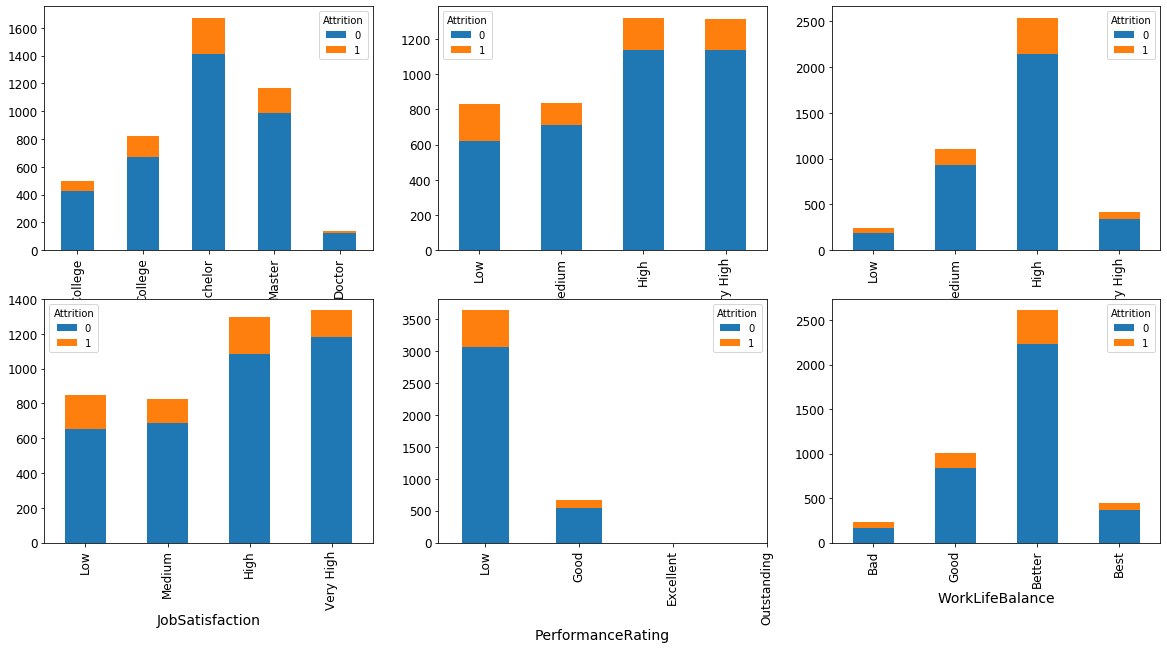

['Education', 'EnvironmentSatisfaction', 'JobInvolvement', 'JobSatisfaction', 'PerformanceRating', 'WorkLifeBalance']


In [318]:
#2. chaning nums as x_ticks to   categorys as x_ticks
fig = plt.figure(figsize=(20,26))
for idx,i in enumerate(zip(cat1,val)):
    crosstab = pd.crosstab(index=dataset[i[0]], columns=dataset["Attrition"])
    ax=plt.subplot(5,3,idx+1)
    crosstab.plot(kind="bar",stacked=True,ax=ax)
    #sns.countplot(x=i[0],data=final_df,ax=ax)
    ax.set(xticks=range(len(i[1])), xticklabels=[j for j in i[1]])
plt.show()
print(list(cat1))

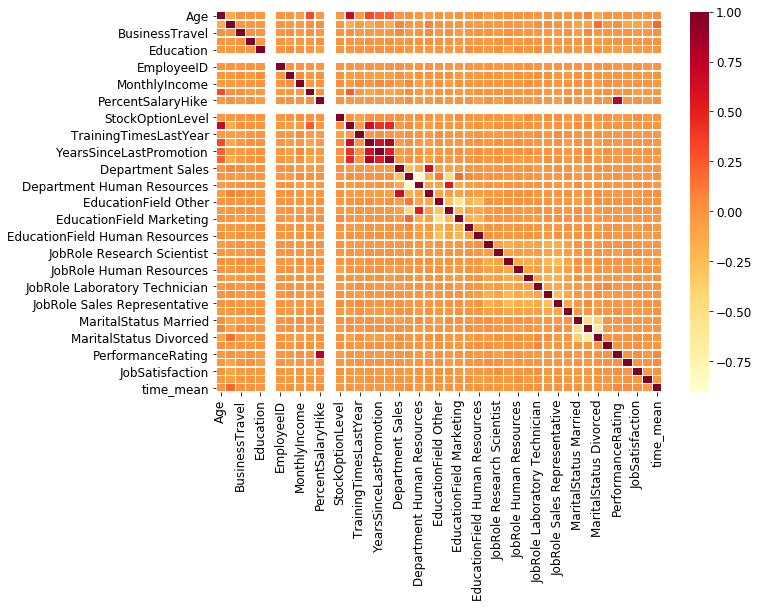

In [254]:
fig, ax = plt.subplots(figsize=(10,7))         # Sample figsize in inches

sns.heatmap(dataset.corr(),cmap='YlOrRd',linewidths=.5,ax=ax)

In [253]:
attrition_lable = dataset['Attrition']
final_ds = dataset.drop('Attrition',1)

learn_ds = final_ds[:4000]
learn_attrition = attrition_lable[:4000]
test_ds = final_ds[4000:]
test_attrition = attrition_lable[4000:]

In [11]:
svr_reg = SVR()
svr_reg.fit(learn_ds, learn_attrition)

pred_ds = svr_reg.predict(learn_ds)
svr_mse = mean_squared_error(learn_attrition, pred_ds)
svr_rmse = np.sqrt(svr_mse)
svr_rmse

svr_scores = cross_val_score(svr_reg, learn_ds, learn_attrition,
                                scoring="neg_mean_squared_error", cv=10)
svr_rmse_scores = np.sqrt(-svr_scores)
display_scores(svr_rmse_scores)

Scores: [0.36328201 0.40499574 0.35210402 0.35778376 0.39995684 0.36331435
 0.35778784 0.36875428 0.40246345 0.36330566]
Mean: 0.3733747945414286
Standard deviation: 0.019536968376349315


In [12]:
list(svr_rmse_scores)

[0.36328201021492407,
 0.40499573500641217,
 0.3521040195346708,
 0.35778376255676053,
 0.3999568372707855,
 0.36331435101895215,
 0.35778784222746834,
 0.36875428272623617,
 0.4024634478617494,
 0.363305656996326]

In [13]:
##########Regression inutile on veut une classification
forest_reg = RandomForestRegressor()
forest_reg.fit(learn_ds, learn_attrition)

pred_ds = forest_reg.predict(learn_ds)
forest_mse = mean_squared_error(learn_attrition, pred_ds)
forest_rmse = np.sqrt(forest_mse)
print(forest_rmse)

forest_scores = cross_val_score(forest_reg, learn_ds, learn_attrition,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)
##########

0.03719677405367299
Scores: [0.10821044 0.0881476  0.10010494 0.13223653 0.07608055 0.09592054
 0.12945752 0.09768572 0.0790522  0.1175351 ]
Mean: 0.10244311531219004
Standard deviation: 0.018427103004361147


In [243]:
clf = make_pipeline(StandardScaler(), SVC(kernel='poly',class_weight="balanced"))
clf.fit(learn_ds, learn_attrition)
predict_score()
clf.score(test_ds,test_attrition)

98.7 %


0.9866666666666667

In [180]:
clf = make_pipeline(StandardScaler(), SGDClassifier(max_iter=200, tol=1e-3))
clf.fit(learn_ds, learn_attrition)
predict_score()
clf.score(test_ds,test_attrition)

0.88
